# Data Preprocessing 
If you've prepreocessed the data in previous machine learning models (e.g. random forest), please skip to the XG Boost specific portion. 

### 1. Loading Relevant Libraries and Dataset

In [58]:
import pandas as pd
import os
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [59]:
# Load dataset. 
df = pd.read_csv("TMDB_tv_dataset_v3.csv")


### 2. Filling Missing Values and Removing Duplicates

In [60]:
# Fill missing values for numerical + categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64', 'bool']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

categorical_cols = df.select_dtypes(include=['object']).columns
columns_to_fill = [col for col in categorical_cols if col != 'genres']
df[columns_to_fill] = df[columns_to_fill].apply(lambda col: col.fillna('Unknown'))

# Remove duplicates
df = df.drop_duplicates()

# Handle 'genres' column (multi-label encoding)
df['genres'] = df['genres'].fillna('Unknown')
df['genres'] = df['genres'].apply(lambda x: x.split(', '))
unique_genres = sorted(set(genre for genres in df['genres'] for genre in genres))

for genre in unique_genres:
    df[genre] = df['genres'].apply(lambda genres: int(genre in genres))


# Retain 'genres' column for now as per the requirement
# Columns to encode
encode_cols = ['original_language', 'type', 'status', 'created_by', 'networks', 'origin_country', 'production_companies']

# One-hot encoding for 'original_language' (top 10 values + 'OTHER')
top_10_original_language = df['original_language'].value_counts(ascending=False).head(10).index.tolist()
for i in top_10_original_language:
    df[f'original-language_{i}'] = np.where(df['original_language'] == i, 1, 0)
df['original-language_OTHER'] = (~df['original_language'].isin(top_10_original_language)).astype(int)
df.drop(columns=['original_language'], inplace=True)
encode_cols.remove('original_language')



### 3. One hot encoding 

In [61]:
# One-hot encoding for 'created_by' (top 10 values + 'OTHER')
filtered_df = df[df['created_by'] != 'Unknown']
top_10_created_by = filtered_df['created_by'].value_counts(ascending=False).head(10).index.tolist()
for i in top_10_created_by:
    df[f'created-by_{i}'] = np.where(df['created_by'] == i, 1, 0)
df['created-by_OTHER'] = (~df['created_by'].isin(top_10_created_by)).astype(int)
df.drop(columns=['created_by'], inplace=True)
encode_cols.remove('created_by')

# One-hot encoding for 'networks' (top 10 values + 'OTHER')
filtered_df = df[df['networks'] != 'Unknown']
top_10_networks = filtered_df['networks'].value_counts(ascending=False).head(10).index.tolist()
for i in top_10_networks:
    df[f'networks_{i}'] = np.where(df['networks'] == i, 1, 0)
df['networks_OTHER'] = (~df['networks'].isin(top_10_networks)).astype(int)
df.drop(columns=['networks'], inplace=True)
encode_cols.remove('networks')

# One-hot encoding for 'origin_country' (top 10 values + 'OTHER')
df['origin_country'] = df['origin_country'].fillna('Unknown')
filtered_df = df[df['origin_country'] != 'Unknown']
top_10_origin_country = filtered_df['origin_country'].value_counts(ascending=False).head(10).index.tolist()
one_hot_encoded = pd.get_dummies(df['origin_country'], prefix='origin-country')
one_hot_encoded = one_hot_encoded[[f'origin-country_{i}' for i in top_10_origin_country if f'origin-country_{i}' in one_hot_encoded]]
one_hot_encoded['origin-country_OTHER'] = (~df['origin_country'].isin(top_10_origin_country)).astype(int)
df = pd.concat([df, one_hot_encoded], axis=1)
df.drop(columns=['origin_country'], inplace=True)
encode_cols.remove('origin_country')

# One-hot encoding for 'production_companies' (top 10 values + 'OTHER')
df['production_companies'] = df['production_companies'].fillna('Unknown')
filtered_df = df[df['production_companies'] != 'Unknown']
top_10_production_companies = filtered_df['production_companies'].value_counts(ascending=False).head(10).index.tolist()
for i in top_10_production_companies:
    df[f'production-companies_{i}'] = np.where(df['production_companies'] == i, 1, 0)
df['production-companies_OTHER'] = (~df['production_companies'].isin(top_10_production_companies)).astype(int)
df.drop(columns=['production_companies'], inplace=True)
encode_cols.remove('production_companies')

# One-hot encoding for remaining columns
for colname in encode_cols:
    df_encoded = pd.get_dummies(df[colname], prefix=colname)
    df = pd.concat([df, df_encoded], axis=1)

# Removing remaining original columns from df
df.drop(columns=encode_cols, axis=1, inplace=True)

# Save the final DataFrame
df.to_csv('TMDB_tv_dataset_v3.csv', index=False)

# Print final DataFrame columns to verify
print(df.columns)

Index(['id', 'name', 'number_of_seasons', 'number_of_episodes', 'vote_count',
       'vote_average', 'overview', 'adult', 'backdrop_path', 'first_air_date',
       ...
       'type_Reality', 'type_Scripted', 'type_Talk Show', 'type_Video',
       'status_Canceled', 'status_Ended', 'status_In Production',
       'status_Pilot', 'status_Planned', 'status_Returning Series'],
      dtype='object', length=111)


### 4. Converting Air Date Columns to Seasons

In [62]:
# Replace "Unknown" and other invalid date strings with NaT (Not a Time)
df['first_air_date'] = pd.to_datetime(df['first_air_date'], format='%Y-%m-%d', errors='coerce')
df['last_air_date'] = pd.to_datetime(df['last_air_date'], format='%Y-%m-%d', errors='coerce')

# Check the data types to confirm conversion
print(df['first_air_date'].dtypes)
print(df['last_air_date'].dtypes)

# Creating a function to determine the season based on the month
def get_season(date):
    if pd.isna(date):  # Handle NaT values
        return 'UNKNOWN'
    month = date.month
    if month in [12, 1, 2]:
        return 'WINTER'
    elif month in [3, 4, 5]:
        return 'SPRING'
    elif month in [6, 7, 8]:
        return 'SUMMER'
    elif month in [9, 10, 11]:
        return 'FALL'
    else:
        return 'UNKNOWN'


# Creating a column with the seasons for `first_air_date`
df['first_air_date_season'] = df['first_air_date'].apply(get_season)

# Creating boolean columns for each season
df['first_air_date_winter'] = (df['first_air_date_season'] == 'WINTER').astype(int)
df['first_air_date_spring'] = (df['first_air_date_season'] == 'SPRING').astype(int)
df['first_air_date_summer'] = (df['first_air_date_season'] == 'SUMMER').astype(int)
df['first_air_date_fall'] = (df['first_air_date_season'] == 'FALL').astype(int)

# Repeating the same process for `last_air_date`
df['last_air_date_season'] = df['last_air_date'].apply(get_season)

df['last_air_date_winter'] = (df['last_air_date_season'] == 'WINTER').astype(int)
df['last_air_date_spring'] = (df['last_air_date_season'] == 'SPRING').astype(int)
df['last_air_date_summer'] = (df['last_air_date_season'] == 'SUMMER').astype(int)
df['last_air_date_fall'] = (df['last_air_date_season'] == 'FALL').astype(int)

# Confirm the columns
print(df[['first_air_date_season', 'last_air_date_season']].head())

datetime64[ns]
datetime64[ns]
  first_air_date_season last_air_date_season
0                SPRING               SPRING
1                SPRING               WINTER
2                SUMMER               SUMMER
3                  FALL                 FALL
4                WINTER                 FALL


### 5. Applying Log Transformation to Numerical Columns 

In [63]:
# List of original numerical columns
numerical_columns = ['number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average', 'popularity', 'episode_run_time']

# Apply log transformation and rename columns with "_log"
df_log = df[numerical_columns].apply(lambda x: np.log1p(x)).add_suffix('_log')

# Concatenate the log-transformed columns with the original DataFrame
df = pd.concat([df, df_log], axis=1)

# Display the DataFrame to confirm new columns
print(df.head())

# List of log-transformed numerical columns
numerical_columns_log = [col + '_log' for col in numerical_columns]

# Display summary statistics for log-transformed columns
print(df[numerical_columns_log].describe())

      id              name  number_of_seasons  number_of_episodes  vote_count  \
0   1399   Game of Thrones                  8                  73       21857   
1  71446       Money Heist                  3                  41       17836   
2  66732   Stranger Things                  4                  34       16161   
3   1402  The Walking Dead                 11                 177       15432   
4  63174           Lucifer                  6                  93       13870   

   vote_average                                           overview  adult  \
0         8.442  Seven noble families fight for control of the ...  False   
1         8.257  To carry out the biggest heist in history, a m...  False   
2         8.624  When a young boy vanishes, a small town uncove...  False   
3         8.121  Sheriff's deputy Rick Grimes awakens from a co...  False   
4         8.486  Bored and unhappy as the Lord of Hell, Lucifer...  False   

                      backdrop_path first_air_date

### 6. Winsorizing Each Log-Transformed Numerical Column

In [64]:
#Winsorization
from scipy.stats.mstats import winsorize

# Define the limits for Winsorization
lower_limit = 0.05  # 5th percentile
upper_limit = 0.95  # 95th percentile

# Winsorize each numerical column in-place
for col in numerical_columns:
    df[col] = winsorize(df[col], limits=(lower_limit, 1 - upper_limit))

# Winsorize each log-transformed numerical column in-place
for col in numerical_columns_log:
    df[col] = winsorize(df[col], limits=(lower_limit, 1 - upper_limit))

### 7. Normalizing Each Winsorized Numerical Column 

In [65]:
# Normalize
from sklearn.preprocessing import MinMaxScaler

# Select numerical columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply scaling in-place
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Display the updated DataFrame to confirm normalized columns
print(df.head())

         id              name  number_of_seasons  number_of_episodes  \
0  0.005565   Game of Thrones               1.00            0.802198   
1  0.284401       Money Heist               0.75            0.450549   
2  0.265636   Stranger Things               1.00            0.373626   
3  0.005577  The Walking Dead               1.00            1.000000   
4  0.251473           Lucifer               1.00            1.000000   

   vote_count  vote_average  \
0         1.0      0.938000   
1         1.0      0.917444   
2         1.0      0.958222   
3         1.0      0.902333   
4         1.0      0.942889   

                                            overview  adult  \
0  Seven noble families fight for control of the ...  False   
1  To carry out the biggest heist in history, a m...  False   
2  When a young boy vanishes, a small town uncove...  False   
3  Sheriff's deputy Rick Grimes awakens from a co...  False   
4  Bored and unhappy as the Lord of Hell, Lucifer...  False   

 

# XG Boost Specific Preprocessing
### Changing Non-numerical Columns into Numerical Ones
XGBoost expects numerical values (int, float, bool) for training, so any non-numeric columns need to be encoded or removed.



### Identifying Non-numerical Columns 

Fun fact: What is unit8? 
- It's an unsigned 8-bit integer, a numerical data type that stores integers ranging from 0 to 255. It is memory-efficient because it uses only 8 bits per value
- Columns with uint8 are typically created when performing one-hot encoding or other binary encoding methods, where the values are restricted to 0 and 1.

In [66]:
# Identify non-numerical columns
non_numerical_columns = df.select_dtypes(exclude=['int64', 'float64', 'uint8']).columns.tolist()

# Print the non-numerical columns
print("Non-Numerical columns:", non_numerical_columns)


Non-Numerical columns: ['name', 'overview', 'adult', 'backdrop_path', 'first_air_date', 'last_air_date', 'homepage', 'in_production', 'original_name', 'poster_path', 'tagline', 'genres', 'languages', 'spoken_languages', 'production_countries', 'first_air_date_season', 'last_air_date_season']


In [67]:
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# Display the list of categorical columns
print("Categorical columns:", categorical_columns)


Categorical columns: ['name', 'overview', 'backdrop_path', 'homepage', 'original_name', 'poster_path', 'tagline', 'genres', 'languages', 'spoken_languages', 'production_countries', 'first_air_date_season', 'last_air_date_season']


We will numerify categorical columns later. First, let's tackle the non-numerical and non-categorical columns...

### Converting Non-Numerical, Non-Categorical Columns to Numerical Ones 
1. Boolean
2. Date-Time 

In [68]:
# filtering out nonnumerical and noncategorical columns: 

# Find columns that are non-numerical and not in categorical
non_numerical_non_categorical = [col for col in non_numerical_columns if col not in categorical_columns]
# Print the result
print("Non-Numerical and Non-Categorical Columns:", non_numerical_non_categorical)

# Check data types of identified columns
print("Data Types of Non-Numerical and Non-Categorical Columns:")
print(df[non_numerical_non_categorical].dtypes)


Non-Numerical and Non-Categorical Columns: ['adult', 'first_air_date', 'last_air_date', 'in_production']
Data Types of Non-Numerical and Non-Categorical Columns:
adult                       bool
first_air_date    datetime64[ns]
last_air_date     datetime64[ns]
in_production               bool
dtype: object


In [69]:
# Convert boolean columns to integers
df['adult'] = df['adult'].astype(int)
df['in_production'] = df['in_production'].astype(int)


In [70]:
# Extract features from first_air_date
df['first_air_year'] = df['first_air_date'].dt.year
df['first_air_month'] = df['first_air_date'].dt.month
df['first_air_day'] = df['first_air_date'].dt.day

# Extract features from last_air_date
df['last_air_year'] = df['last_air_date'].dt.year
df['last_air_month'] = df['last_air_date'].dt.month
df['last_air_day'] = df['last_air_date'].dt.day

# Optionally, calculate the duration between first_air_date and last_air_date
df['air_duration_days'] = (df['last_air_date'] - df['first_air_date']).dt.days

# Drop the original datetime columns if no longer needed
df.drop(columns=['first_air_date', 'last_air_date'], inplace=True)


Let's check to see if our code worked! 

In [71]:
# Identify non-numerical columns
non_numerical_columns = df.select_dtypes(exclude=['int64', 'float64', 'uint8']).columns.tolist()

# List of categorical columns (predefined)
categorical_columns = ['name', 'overview', 'backdrop_path', 'homepage', 'original_name', 
                       'poster_path', 'tagline', 'genres', 'languages', 
                       'spoken_languages', 'production_countries', 
                       'first_air_date_season', 'last_air_date_season']


# Compare both lists
if set(non_numerical_columns) == set(categorical_columns):
    print("Non-Numerical Columns match Categorical Columns!")
else:
    print("Mismatch Detected!")
    print("Non-Numerical Columns:", non_numerical_columns)
    print("Categorical Columns:", categorical_columns)



Non-Numerical Columns match Categorical Columns!


## Converting Categorical Columns to Numerical Ones 

### Step 1: Drop Columns with Limited Predictive Value
Columns like backdrop_path, homepage, poster_path, name, original_name are unlikely to provide meaningful input for the model, so drop them:

In [72]:
df.drop(columns=['backdrop_path', 'homepage', 'poster_path', 'name', 'original_name'], inplace=True)


### Step 2: Encode Multi-Label Columns (genres, languages, spoken_languages, production_countries)

In [73]:
# Handle 'genres' column (multi-label encoding)
unique_genres = sorted(set(genre for genres in df['genres'] for genre in genres))

for genre in unique_genres:
    df[f'genre_{genre}'] = df['genres'].apply(lambda genres: int(genre in genres))
df.drop(columns=['genres'], inplace=True)

# One-hot encode top 10 languages
top_languages = df['languages'].value_counts().head(10).index.tolist()
for lang in top_languages:
    df[f'language_{lang}'] = df['languages'].apply(lambda x: int(lang in x))
df['language_OTHER'] = ~df['languages'].isin(top_languages)
df.drop(columns=['languages'], inplace=True)

# One-hot encode top 10 spoken languages
top_spoken_languages = df['spoken_languages'].value_counts().head(10).index.tolist()
for lang in top_spoken_languages:
    df[f'spoken_language_{lang}'] = df['spoken_languages'].apply(lambda x: int(lang in x))
df['spoken_language_OTHER'] = ~df['spoken_languages'].isin(top_spoken_languages)
df.drop(columns=['spoken_languages'], inplace=True)

# One-hot encode top 10 production countries
top_countries = df['production_countries'].value_counts().head(10).index.tolist()
for country in top_countries:
    df[f'production_country_{country}'] = df['production_countries'].apply(lambda x: int(country in x))
df['production_country_OTHER'] = ~df['production_countries'].isin(top_countries)
df.drop(columns=['production_countries'], inplace=True)

### Step 3: Encode Small-Cardinality Columns (first_air_date_season, last_air_date_season)

In [74]:
# One-hot encode `first_air_date_season`
df = pd.get_dummies(df, columns=['first_air_date_season'], prefix='first_air_season', drop_first=True)

# One-hot encode `last_air_date_season`
df = pd.get_dummies(df, columns=['last_air_date_season'], prefix='last_air_season', drop_first=True)


### Step 4: Vectorize Text Columns (overview, tagline) with TF-IDF. 

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Replace NaN values with empty strings
df['overview'] = df['overview'].fillna('')
df['tagline'] = df['tagline'].fillna('')

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')  # Adjust max_features as needed

# Fit and transform the 'overview' column
overview_tfidf = tfidf_vectorizer.fit_transform(df['overview'])

# Transform the 'tagline' column
tagline_tfidf = tfidf_vectorizer.fit_transform(df['tagline'])

# Convert 'overview' TF-IDF matrix to DataFrame
overview_tfidf_df = pd.DataFrame(overview_tfidf.toarray(), columns=[f'overview_{i}' for i in range(overview_tfidf.shape[1])])

# Convert 'tagline' TF-IDF matrix to DataFrame
tagline_tfidf_df = pd.DataFrame(tagline_tfidf.toarray(), columns=[f'tagline_{i}' for i in range(tagline_tfidf.shape[1])])

# Concatenate TF-IDF features with the original DataFrame
df = pd.concat([df, overview_tfidf_df, tagline_tfidf_df], axis=1)

# Drop original 'overview' and 'tagline' columns if no longer needed
df.drop(columns=['overview', 'tagline'], inplace=True)

print(df.head())
print(df.shape)  # Check the new shape of the DataFrame



         id  number_of_seasons  number_of_episodes  vote_count  vote_average  \
0  0.005565               1.00            0.802198         1.0      0.938000   
1  0.284401               0.75            0.450549         1.0      0.917444   
2  0.265636               1.00            0.373626         1.0      0.958222   
3  0.005577               1.00            1.000000         1.0      0.902333   
4  0.251473               1.00            1.000000         1.0      0.942889   

   adult  in_production  popularity  episode_run_time  Action & Adventure  \
0    0.0            0.0         1.0              0.00                 1.0   
1    0.0            0.0         1.0              1.00                 0.0   
2    0.0            1.0         1.0              0.00                 0.0   
3    0.0            0.0         1.0              0.70                 1.0   
4    0.0            0.0         1.0              0.75                 0.0   

   ...  tagline_490  tagline_491  tagline_492  tagline_4

### Step 5: Verify everything is numerical. 

In [76]:
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# Display the list of categorical columns
print("Categorical columns:", categorical_columns)


Categorical columns: ['language_OTHER', 'spoken_language_OTHER', 'production_country_OTHER']


In [77]:
# Inspect the data types
print(df[['language_OTHER', 'spoken_language_OTHER', 'production_country_OTHER']].dtypes)

# Display sample values
print(df[['language_OTHER', 'spoken_language_OTHER', 'production_country_OTHER']].head())


language_OTHER              object
spoken_language_OTHER       object
production_country_OTHER    object
dtype: object
  language_OTHER spoken_language_OTHER production_country_OTHER
0          False                 False                     True
1          False                 False                     True
2          False                 False                    False
3          False                 False                    False
4          False                 False                    False


In [78]:
# Drop the unnecessary columns
df.drop(columns=['language_OTHER', 'spoken_language_OTHER', 'production_country_OTHER'], inplace=True)

# Verify columns are dropped
print("Remaining columns:", df.columns)





Remaining columns: Index(['id', 'number_of_seasons', 'number_of_episodes', 'vote_count',
       'vote_average', 'adult', 'in_production', 'popularity',
       'episode_run_time', 'Action & Adventure',
       ...
       'tagline_490', 'tagline_491', 'tagline_492', 'tagline_493',
       'tagline_494', 'tagline_495', 'tagline_496', 'tagline_497',
       'tagline_498', 'tagline_499'],
      dtype='object', length=1178)


In [79]:
# Identify non-numerical columns
non_numerical_columns = df.select_dtypes(exclude=['int64', 'float64', 'uint8']).columns.tolist()

# Print any remaining non-numerical columns
if not non_numerical_columns:
    print("All columns are numerical!")
else:
    print("Remaining Non-Numerical Columns:", non_numerical_columns)


All columns are numerical!


# XG-Boost Training 

In [80]:
# Drop the 'popularity_log' column if it exists
if 'popularity_log' in df.columns:
    df = df.drop(columns=['popularity_log'])
    print("'popularity_log' column has been successfully dropped.")
else:
    print("'popularity_log' column does not exist in the DataFrame.")


'popularity_log' column has been successfully dropped.


In [81]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Split data into features (X) and target (y)
y = df['popularity']
X = df.drop(columns=['id', 'popularity'])  # Drop ID and target column

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine X_train and y_train to handle missing values together
train_combined = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
train_combined = train_combined.dropna()  # Remove rows with missing values

# Split back into X_train and y_train
X_train = train_combined.drop(columns=['popularity']).to_numpy()
y_train = train_combined['popularity'].to_numpy()

# Combine X_test and y_test to handle missing values together
test_combined = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
test_combined = test_combined.dropna()  # Remove rows with missing values

# Split back into X_test and y_test
X_test = test_combined.drop(columns=['popularity']).to_numpy()
y_test = test_combined['popularity'].to_numpy()

# Verify data integrity
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

print("Missing values in X_train:", np.isnan(X_train).sum())
print("Missing values in y_train:", np.isnan(y_train).sum())
print("Missing values in X_test:", np.isnan(X_test).sum())
print("Missing values in y_test:", np.isnan(y_test).sum())

print("Infinite values in X_train:", np.isinf(X_train).sum())
print("Infinite values in y_train:", np.isinf(y_train).sum())
print("Infinite values in X_test:", np.isinf(X_test).sum())
print("Infinite values in y_test:", np.isinf(y_test).sum())

# Initialize the model
xgb = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, random_state=42)

# Train the model
xgb.fit(X_train, y_train)

# Make predictions
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

# Evaluate the model
train_mae = mean_absolute_error(y_train, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))  
train_r2 = r2_score(y_train, y_pred_train)

test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))  
test_r2 = r2_score(y_test, y_pred_test)

# Print results
print("Results with XGBoost:")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")  
print(f"Train R^2: {train_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}") 
print(f"Test R^2: {test_r2:.4f}")





X_train shape: (107009, 1175)
y_train shape: (107009,)
X_test shape: (26770, 1175)
y_test shape: (26770,)
Missing values in X_train: 0
Missing values in y_train: 0
Missing values in X_test: 0
Missing values in y_test: 0
Infinite values in X_train: 0
Infinite values in y_train: 0
Infinite values in X_test: 0
Infinite values in y_test: 0
Results with XGBoost:
Train MAE: 0.0776
Train RMSE: 0.1406
Train R^2: 0.7406
Test MAE: 0.0812
Test RMSE: 0.1496
Test R^2: 0.7017


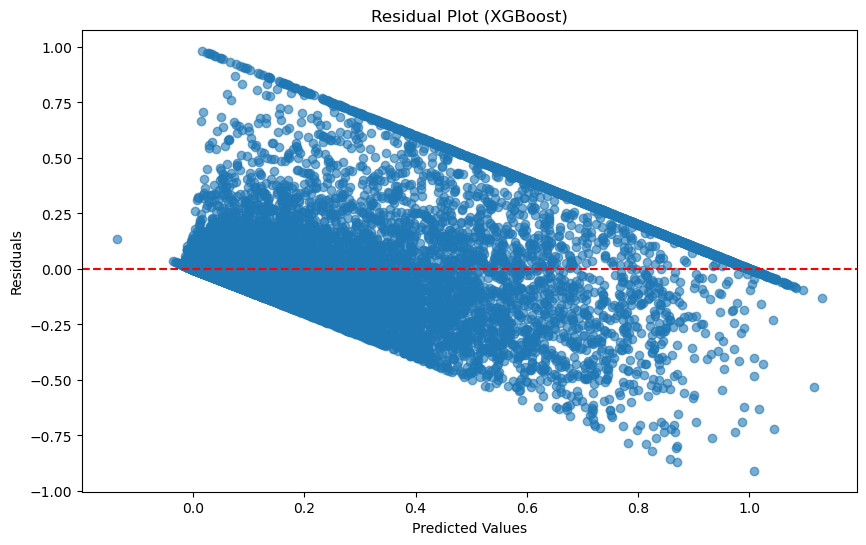

Top 10 Important Features
                      Feature  Importance
2                  vote_count    0.113444
1          number_of_episodes    0.030683
138               language_en    0.016922
103        last_air_date_fall    0.014551
95    status_Returning Series    0.011282
61          origin-country_US    0.010940
112             last_air_year    0.010228
29       original-language_zh    0.009403
1140              tagline_465    0.008646
3                vote_average    0.007628


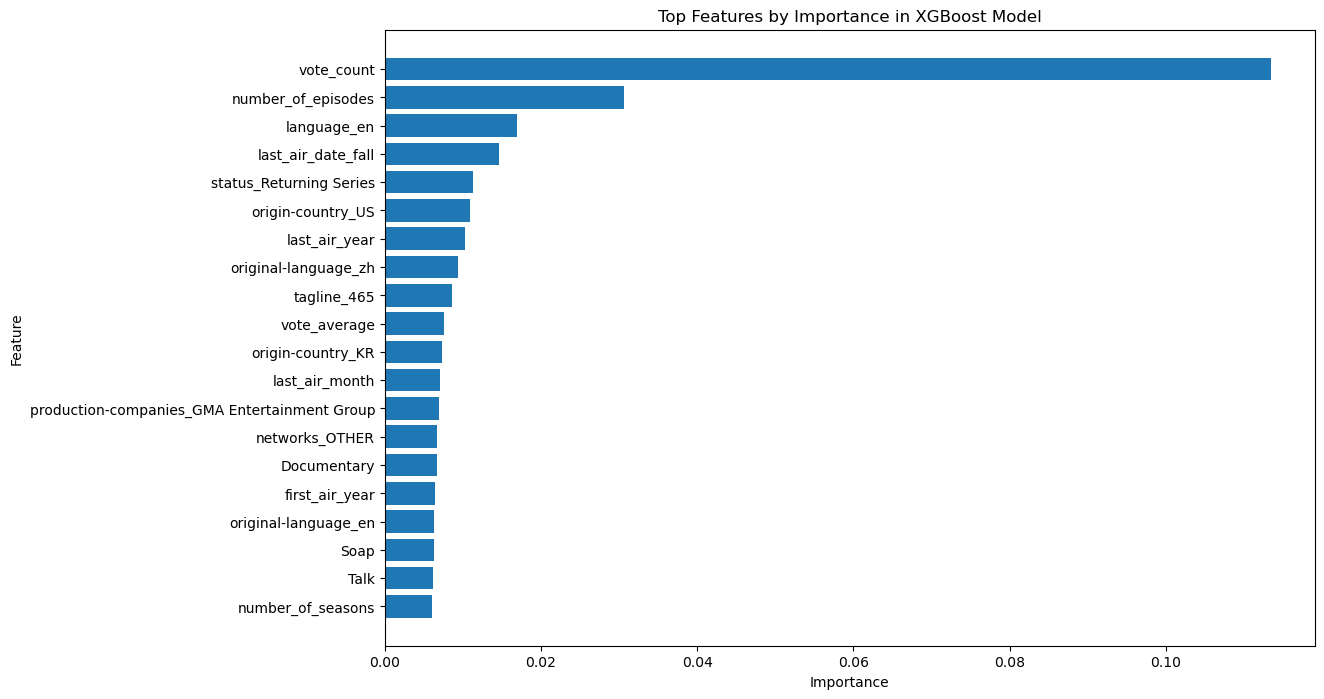

In [33]:
# Residual Plot
residuals = y_test - y_pred_test
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (XGBoost)')
plt.show()

# Feature Importance Plot
feature_importances = xgb.feature_importances_

# Create a DataFrame with feature names and their importances, excluding 'popularity_log'
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the top 10 important features 
print("Top 10 Important Features")
print(features_df.head(10))

# Visualize the top 20 features
plt.figure(figsize=(12, 8))
plt.barh(features_df['Feature'].head(20), features_df['Importance'].head(20))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top Features by Importance in XGBoost Model')
plt.gca().invert_yaxis()  # To have the most important feature on top
plt.show()


X_train_top20 shape: (107009, 20)
y_train_top20 shape: (107009,)
X_test_top20 shape: (26770, 20)
y_test_top20 shape: (26770,)
Results with XGBoost using Top 20 Features:
Train MAE: 0.0817
Train RMSE: 0.1477
Train R^2: 0.7137
Test MAE: 0.0848
Test RMSE: 0.1550
Test R^2: 0.6798


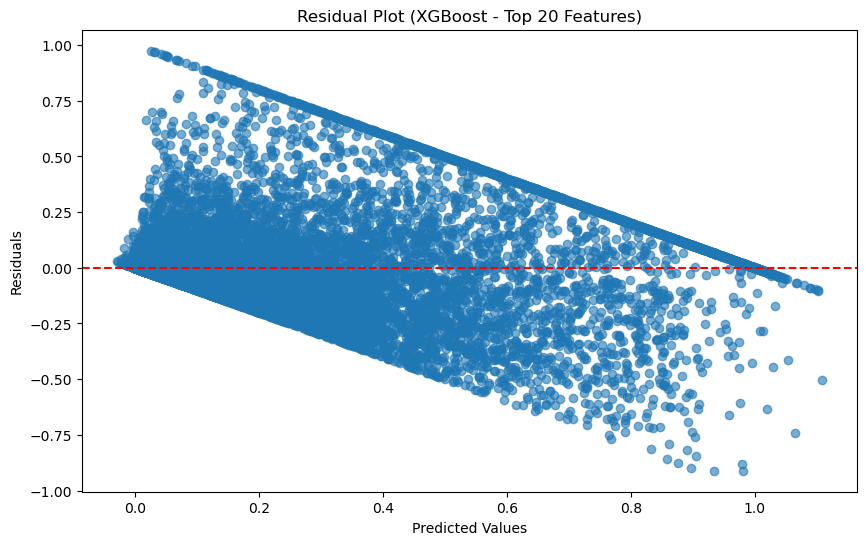

In [34]:
# Select top 20 features
top_20_features = features_df['Feature'].head(20).values
X_top20 = X[top_20_features]

# Split the dataset into train and test sets
X_train_top20, X_test_top20, y_train_top20, y_test_top20 = train_test_split(X_top20, y, test_size=0.2, random_state=42)

# Combine X_train and y_train to handle missing values together
train_combined_top20 = pd.concat([X_train_top20.reset_index(drop=True), y_train_top20.reset_index(drop=True)], axis=1)
train_combined_top20 = train_combined_top20.dropna()  # Remove rows with missing values

# Split back into X_train and y_train
X_train_top20 = train_combined_top20.drop(columns=['popularity']).to_numpy()
y_train_top20 = train_combined_top20['popularity'].to_numpy()

# Combine X_test and y_test to handle missing values together
test_combined_top20 = pd.concat([X_test_top20.reset_index(drop=True), y_test_top20.reset_index(drop=True)], axis=1)
test_combined_top20 = test_combined_top20.dropna()  # Remove rows with missing values

# Split back into X_test and y_test
X_test_top20 = test_combined_top20.drop(columns=['popularity']).to_numpy()
y_test_top20 = test_combined_top20['popularity'].to_numpy()

# Verify data integrity
print("X_train_top20 shape:", X_train_top20.shape)
print("y_train_top20 shape:", y_train_top20.shape)
print("X_test_top20 shape:", X_test_top20.shape)
print("y_test_top20 shape:", y_test_top20.shape)

# Initialize the model
xgb_top20 = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, random_state=42)

# Train the model
xgb_top20.fit(X_train_top20, y_train_top20)

# Make predictions
y_pred_train_top20 = xgb_top20.predict(X_train_top20)
y_pred_test_top20 = xgb_top20.predict(X_test_top20)

# Evaluate the model
train_mae_top20 = mean_absolute_error(y_train_top20, y_pred_train_top20)
train_rmse_top20 = np.sqrt(mean_squared_error(y_train_top20, y_pred_train_top20))  
train_r2_top20 = r2_score(y_train_top20, y_pred_train_top20)

test_mae_top20 = mean_absolute_error(y_test_top20, y_pred_test_top20)
test_rmse_top20 = np.sqrt(mean_squared_error(y_test_top20, y_pred_test_top20))  
test_r2_top20 = r2_score(y_test_top20, y_pred_test_top20)

# Print results
print("Results with XGBoost using Top 20 Features:")
print(f"Train MAE: {train_mae_top20:.4f}")
print(f"Train RMSE: {train_rmse_top20:.4f}")  
print(f"Train R^2: {train_r2_top20:.4f}")
print(f"Test MAE: {test_mae_top20:.4f}")
print(f"Test RMSE: {test_rmse_top20:.4f}") 
print(f"Test R^2: {test_r2_top20:.4f}")

# Residual Plot
residuals_top20 = y_test_top20 - y_pred_test_top20
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test_top20, residuals_top20, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (XGBoost - Top 20 Features)')
plt.show()


X_train_top10 shape: (109232, 10)
y_train_top10 shape: (109232,)
X_test_top10 shape: (27375, 10)
y_test_top10 shape: (27375,)
Results with XGBoost using Top 10 Features:
Train MAE: 0.0853
Train RMSE: 0.1544
Train R^2: 0.6834
Test MAE: 0.0876
Test RMSE: 0.1600
Test R^2: 0.6541


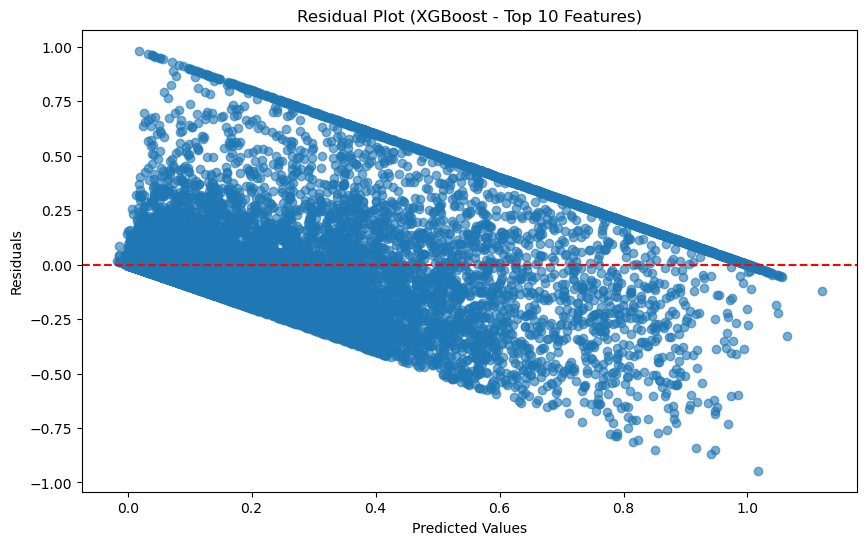

In [35]:
# Select top 10 features
top_10_features = features_df['Feature'].head(10).values
X_top10 = X[top_10_features]

# Split the dataset into train and test sets
X_train_top10, X_test_top10, y_train_top10, y_test_top10 = train_test_split(X_top10, y, test_size=0.2, random_state=42)

# Combine X_train and y_train to handle missing values together
train_combined_top10 = pd.concat([X_train_top10.reset_index(drop=True), y_train_top10.reset_index(drop=True)], axis=1)
train_combined_top10 = train_combined_top10.dropna()  # Remove rows with missing values

# Split back into X_train and y_train
X_train_top10 = train_combined_top10.drop(columns=['popularity']).to_numpy()
y_train_top10 = train_combined_top10['popularity'].to_numpy()

# Combine X_test and y_test to handle missing values together
test_combined_top10 = pd.concat([X_test_top10.reset_index(drop=True), y_test_top10.reset_index(drop=True)], axis=1)
test_combined_top10 = test_combined_top10.dropna()  # Remove rows with missing values

# Split back into X_test and y_test
X_test_top10 = test_combined_top10.drop(columns=['popularity']).to_numpy()
y_test_top10 = test_combined_top10['popularity'].to_numpy()

# Verify data integrity
print("X_train_top10 shape:", X_train_top10.shape)
print("y_train_top10 shape:", y_train_top10.shape)
print("X_test_top10 shape:", X_test_top10.shape)
print("y_test_top10 shape:", y_test_top10.shape)

# Initialize the model
xgb_top10 = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, random_state=42)

# Train the model
xgb_top10.fit(X_train_top10, y_train_top10)

# Make predictions
y_pred_train_top10 = xgb_top10.predict(X_train_top10)
y_pred_test_top10 = xgb_top10.predict(X_test_top10)

# Evaluate the model
train_mae_top10 = mean_absolute_error(y_train_top10, y_pred_train_top10)
train_rmse_top10 = np.sqrt(mean_squared_error(y_train_top10, y_pred_train_top10))  
train_r2_top10 = r2_score(y_train_top10, y_pred_train_top10)

test_mae_top10 = mean_absolute_error(y_test_top10, y_pred_test_top10)
test_rmse_top10 = np.sqrt(mean_squared_error(y_test_top10, y_pred_test_top10))  
test_r2_top10 = r2_score(y_test_top10, y_pred_test_top10)

# Print results
print("Results with XGBoost using Top 10 Features:")
print(f"Train MAE: {train_mae_top10:.4f}")
print(f"Train RMSE: {train_rmse_top10:.4f}")  
print(f"Train R^2: {train_r2_top10:.4f}")
print(f"Test MAE: {test_mae_top10:.4f}")
print(f"Test RMSE: {test_rmse_top10:.4f}") 
print(f"Test R^2: {test_r2_top10:.4f}")

# Residual Plot
residuals_top10 = y_test_top10 - y_pred_test_top10
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test_top10, residuals_top10, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (XGBoost - Top 10 Features)')
plt.show()


X_train_top100 shape: (107009, 100)
y_train_top100 shape: (107009,)
X_test_top100 shape: (26770, 100)
y_test_top100 shape: (26770,)
Results with XGBoost using Top 100 Features:
Train MAE: 0.0766
Train RMSE: 0.1397
Train R^2: 0.7439
Test MAE: 0.0802
Test RMSE: 0.1484
Test R^2: 0.7064


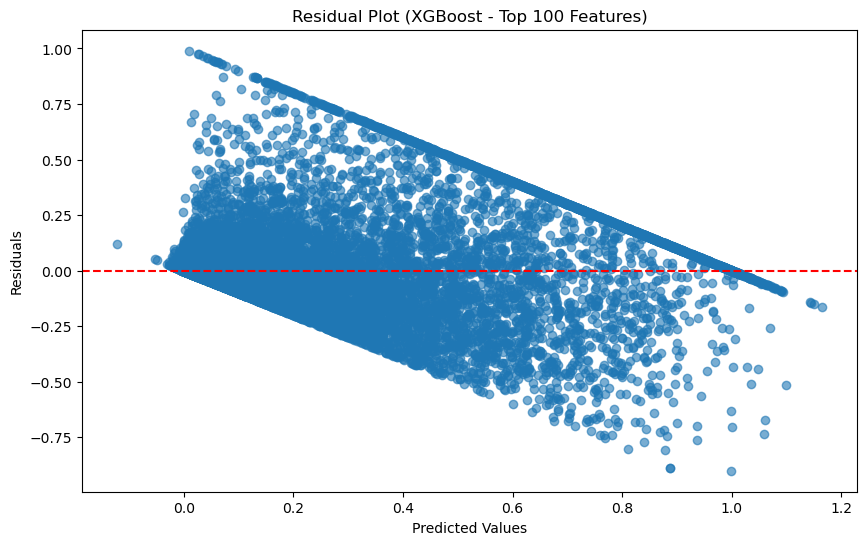

In [36]:
# Select top 100 features
top_100_features = features_df['Feature'].head(100).values
X_top100 = X[top_100_features]

# Split the dataset into train and test sets
X_train_top100, X_test_top100, y_train_top100, y_test_top100 = train_test_split(X_top100, y, test_size=0.2, random_state=42)

# Combine X_train and y_train to handle missing values together
train_combined_top100 = pd.concat([X_train_top100.reset_index(drop=True), y_train_top100.reset_index(drop=True)], axis=1)
train_combined_top100 = train_combined_top100.dropna()  # Remove rows with missing values

# Split back into X_train and y_train
X_train_top100 = train_combined_top100.drop(columns=['popularity']).to_numpy()
y_train_top100 = train_combined_top100['popularity'].to_numpy()

# Combine X_test and y_test to handle missing values together
test_combined_top100 = pd.concat([X_test_top100.reset_index(drop=True), y_test_top100.reset_index(drop=True)], axis=1)
test_combined_top100 = test_combined_top100.dropna()  # Remove rows with missing values

# Split back into X_test and y_test
X_test_top100 = test_combined_top100.drop(columns=['popularity']).to_numpy()
y_test_top100 = test_combined_top100['popularity'].to_numpy()

# Verify data integrity
print("X_train_top100 shape:", X_train_top100.shape)
print("y_train_top100 shape:", y_train_top100.shape)
print("X_test_top100 shape:", X_test_top100.shape)
print("y_test_top100 shape:", y_test_top100.shape)

# Initialize the model
xgb_top100 = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, random_state=42)

# Train the model
xgb_top100.fit(X_train_top100, y_train_top100)

# Make predictions
y_pred_train_top100 = xgb_top100.predict(X_train_top100)
y_pred_test_top100 = xgb_top100.predict(X_test_top100)

# Evaluate the model
train_mae_top100 = mean_absolute_error(y_train_top100, y_pred_train_top100)
train_rmse_top100 = np.sqrt(mean_squared_error(y_train_top100, y_pred_train_top100))  
train_r2_top100 = r2_score(y_train_top100, y_pred_train_top100)

test_mae_top100 = mean_absolute_error(y_test_top100, y_pred_test_top100)
test_rmse_top100 = np.sqrt(mean_squared_error(y_test_top100, y_pred_test_top100))  
test_r2_top100 = r2_score(y_test_top100, y_pred_test_top100)

# Print results
print("Results with XGBoost using Top 100 Features:")
print(f"Train MAE: {train_mae_top100:.4f}")
print(f"Train RMSE: {train_rmse_top100:.4f}")  
print(f"Train R^2: {train_r2_top100:.4f}")
print(f"Test MAE: {test_mae_top100:.4f}")
print(f"Test RMSE: {test_rmse_top100:.4f}") 
print(f"Test R^2: {test_r2_top100:.4f}")

# Residual Plot
residuals_top100 = y_test_top100 - y_pred_test_top100
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test_top100, residuals_top100, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (XGBoost - Top 100 Features)')
plt.show()


In [37]:


def evaluate_model_with_specified_features(X, y, features_df, feature_counts=[10, 50, 100, 500, 1000], plot_title="Model Evaluation with Different Feature Counts"):
    """
    Evaluates model performance with specified numbers of features and compares MAE, RMSE, and R².

    Parameters:
    - X: DataFrame of features
    - y: Series of target variable
    - features_df: DataFrame with feature importances
    - feature_counts: List of the number of top features to evaluate (e.g., [10, 50, 100, 500, 1000])
    - plot_title: Title of the plot

    Returns:
    - A plot comparing the performance metrics (MAE, RMSE, R²) for each feature subset
    """
    # Initialize lists to store evaluation metrics
    mae_list = []
    rmse_list = []
    r2_list = []
    feature_count_list = []

    # Add 'All Features' as a comparison
    feature_counts = feature_counts + ['All Features']

    for feature_count in feature_counts:
        if feature_count == 'All Features':
            X_selected = X  # Use all features
        else:
            # Select the top 'feature_count' most important features
            top_features = features_df['Feature'].head(feature_count).values
            X_selected = X[top_features]

        # Split the dataset into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

        # Handle missing values in both training and test sets
        combined_train = pd.concat([X_train, y_train], axis=1).dropna()
        X_train = combined_train.drop(columns=['popularity'])
        y_train = combined_train['popularity']

        combined_test = pd.concat([X_test, y_test], axis=1).dropna()
        X_test = combined_test.drop(columns=['popularity'])
        y_test = combined_test['popularity']

        # Verify data integrity
        print(f"Using {feature_count} features:")
        print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

        # Initialize the model
        xgb = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, random_state=42)

        # Train the model
        xgb.fit(X_train, y_train)

        # Make predictions
        y_pred_train = xgb.predict(X_train)
        y_pred_test = xgb.predict(X_test)

        # Evaluate the model
        train_mae = mean_absolute_error(y_train, y_pred_train)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        train_r2 = r2_score(y_train, y_pred_train)

        test_mae = mean_absolute_error(y_test, y_pred_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        test_r2 = r2_score(y_test, y_pred_test)

        # Append the results to the lists
        mae_list.append(test_mae)
        rmse_list.append(test_rmse)
        r2_list.append(test_r2)
        feature_count_list.append(feature_count)

    # Plot the results for MAE, RMSE, and R² comparison
    plt.figure(figsize=(12, 8))

    # Plot MAE
    plt.subplot(3, 1, 1)
    plt.plot(feature_count_list, mae_list, marker='o', color='b', label='Test MAE')
    plt.xlabel('Number of Features')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title(f'{plot_title} - MAE')
    plt.xticks(rotation=45)

    # Plot RMSE
    plt.subplot(3, 1, 2)
    plt.plot(feature_count_list, rmse_list, marker='o', color='g', label='Test RMSE')
    plt.xlabel('Number of Features')
    plt.ylabel('Root Mean Squared Error (RMSE)')
    plt.title(f'{plot_title} - RMSE')
    plt.xticks(rotation=45)

    # Plot R²
    plt.subplot(3, 1, 3)
    plt.plot(feature_count_list, r2_list, marker='o', color='r', label='Test R²')
    plt.xlabel('Number of Features')
    plt.ylabel('R²')
    plt.title(f'{plot_title} - R²')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Output the best number of features based on the highest R² and lowest MAE/RMSE
    highest_r2 = feature_count_list[np.argmax(r2_list)]  # Maximize R²
    lowest_mae = feature_count_list[np.argmin(mae_list)]
    lowest_rmse = feature_count_list[np.argmin(rmse_list)]

    # Print results with full precision
    print(f"Highest R^2: {highest_r2}, score: {r2_list[np.argmax(r2_list)]:.4f}")
    print(f"Lowest MAE: {lowest_mae}, score: {mae_list[np.argmin(mae_list)]:.4f}")
    print(f"Lowest RMSE: {lowest_rmse}, score: {rmse_list[np.argmin(rmse_list)]:.4f}")

    
 

Using 10 features:
X_train shape: (109232, 10), y_train shape: (109232,)
X_test shape: (27375, 10), y_test shape: (27375,)
Using 50 features:
X_train shape: (107009, 50), y_train shape: (107009,)
X_test shape: (26770, 50), y_test shape: (26770,)
Using 100 features:
X_train shape: (107009, 100), y_train shape: (107009,)
X_test shape: (26770, 100), y_test shape: (26770,)
Using 500 features:
X_train shape: (107009, 500), y_train shape: (107009,)
X_test shape: (26770, 500), y_test shape: (26770,)
Using 1000 features:
X_train shape: (107009, 1000), y_train shape: (107009,)
X_test shape: (26770, 1000), y_test shape: (26770,)
Using All Features features:
X_train shape: (107009, 1175), y_train shape: (107009,)
X_test shape: (26770, 1175), y_test shape: (26770,)


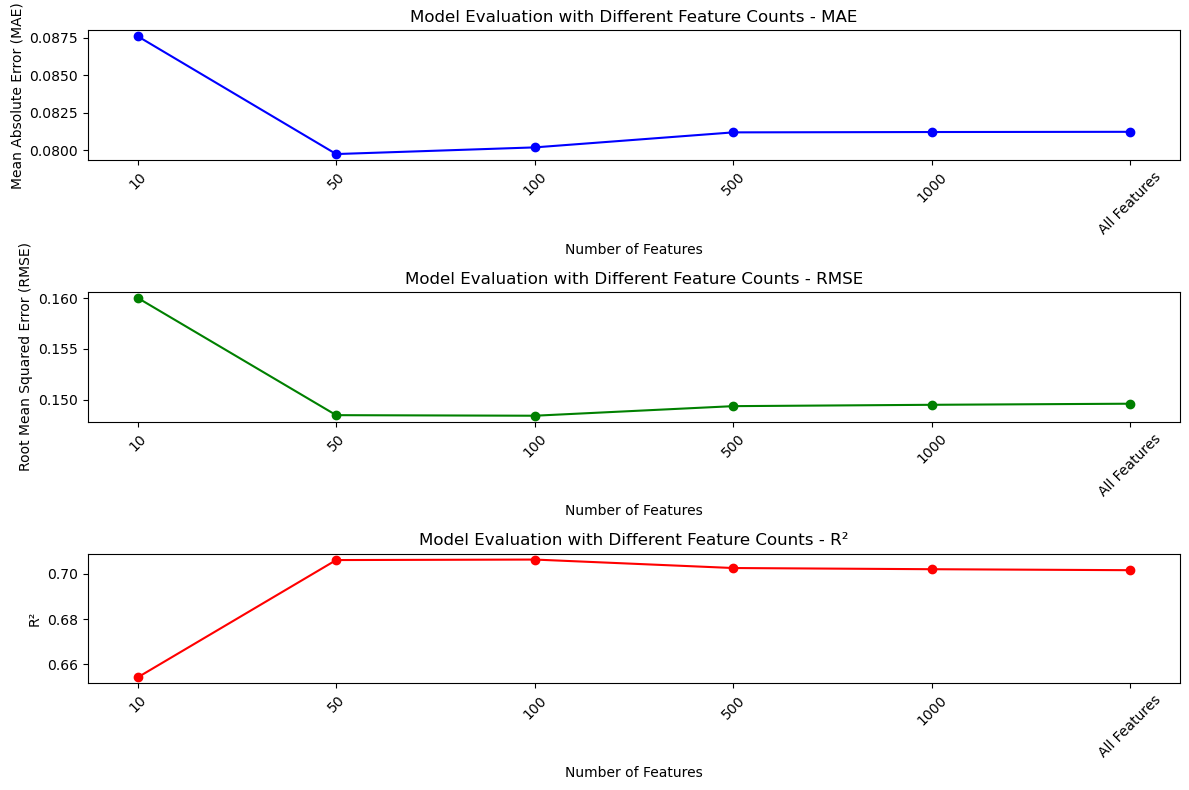

Highest R^2: 100, score: 0.7064
Lowest MAE: 50, score: 0.0797
Lowest RMSE: 100, score: 0.1484


In [38]:
evaluate_model_with_specified_features(X, y, features_df, feature_counts=[10, 50, 100, 500, 1000])

Using 25 features:
X_train shape: (107009, 25), y_train shape: (107009,)
X_test shape: (26770, 25), y_test shape: (26770,)
Using 50 features:
X_train shape: (107009, 50), y_train shape: (107009,)
X_test shape: (26770, 50), y_test shape: (26770,)
Using 75 features:
X_train shape: (107009, 75), y_train shape: (107009,)
X_test shape: (26770, 75), y_test shape: (26770,)
Using 100 features:
X_train shape: (107009, 100), y_train shape: (107009,)
X_test shape: (26770, 100), y_test shape: (26770,)
Using 125 features:
X_train shape: (107009, 125), y_train shape: (107009,)
X_test shape: (26770, 125), y_test shape: (26770,)
Using 150 features:
X_train shape: (107009, 150), y_train shape: (107009,)
X_test shape: (26770, 150), y_test shape: (26770,)
Using 175 features:
X_train shape: (107009, 175), y_train shape: (107009,)
X_test shape: (26770, 175), y_test shape: (26770,)
Using All Features features:
X_train shape: (107009, 1175), y_train shape: (107009,)
X_test shape: (26770, 1175), y_test shape:

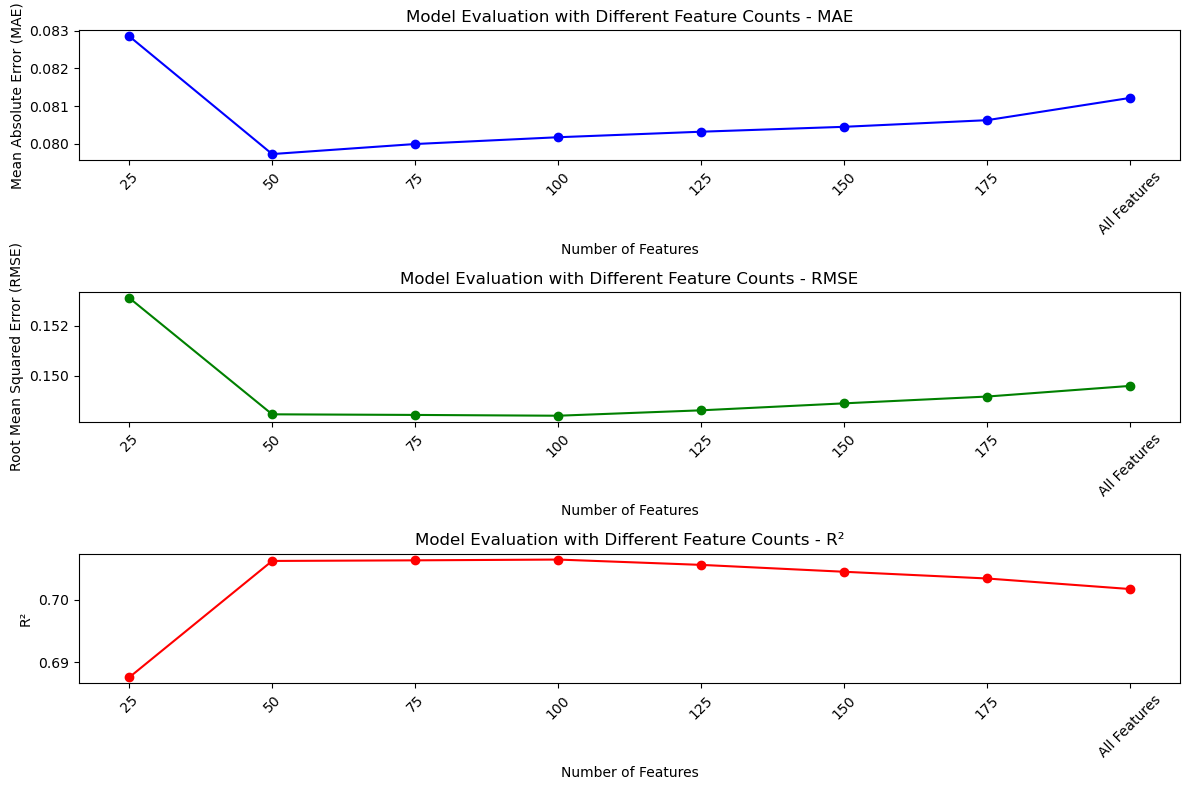

Highest R^2: 100, score: 0.7064
Lowest MAE: 50, score: 0.0797
Lowest RMSE: 100, score: 0.1484


In [39]:
evaluate_model_with_specified_features(X, y, features_df, feature_counts=[25, 50, 75, 100, 125, 150, 175])


Using 90 features:
X_train shape: (107009, 90), y_train shape: (107009,)
X_test shape: (26770, 90), y_test shape: (26770,)
Using 95 features:
X_train shape: (107009, 95), y_train shape: (107009,)
X_test shape: (26770, 95), y_test shape: (26770,)
Using 100 features:
X_train shape: (107009, 100), y_train shape: (107009,)
X_test shape: (26770, 100), y_test shape: (26770,)
Using 105 features:
X_train shape: (107009, 105), y_train shape: (107009,)
X_test shape: (26770, 105), y_test shape: (26770,)
Using 110 features:
X_train shape: (107009, 110), y_train shape: (107009,)
X_test shape: (26770, 110), y_test shape: (26770,)
Using All Features features:
X_train shape: (107009, 1175), y_train shape: (107009,)
X_test shape: (26770, 1175), y_test shape: (26770,)


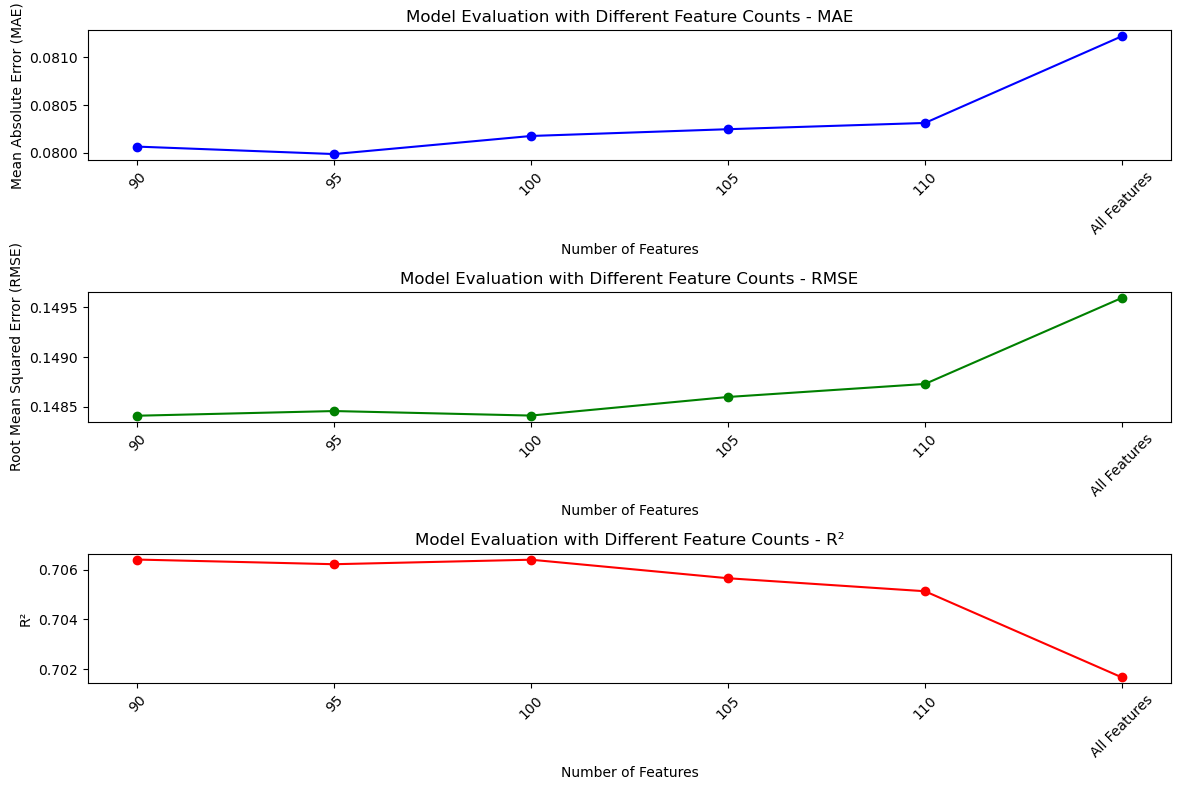

Highest R^2: 90, score: 0.7064
Lowest MAE: 95, score: 0.0800
Lowest RMSE: 90, score: 0.1484


In [40]:
evaluate_model_with_specified_features(X, y, features_df, feature_counts=[90,95,100,105,110])


Using 87 features:
X_train shape: (107009, 87), y_train shape: (107009,)
X_test shape: (26770, 87), y_test shape: (26770,)
Using 88 features:
X_train shape: (107009, 88), y_train shape: (107009,)
X_test shape: (26770, 88), y_test shape: (26770,)
Using 89 features:
X_train shape: (107009, 89), y_train shape: (107009,)
X_test shape: (26770, 89), y_test shape: (26770,)
Using 90 features:
X_train shape: (107009, 90), y_train shape: (107009,)
X_test shape: (26770, 90), y_test shape: (26770,)
Using 91 features:
X_train shape: (107009, 91), y_train shape: (107009,)
X_test shape: (26770, 91), y_test shape: (26770,)
Using 92 features:
X_train shape: (107009, 92), y_train shape: (107009,)
X_test shape: (26770, 92), y_test shape: (26770,)
Using All Features features:
X_train shape: (107009, 1175), y_train shape: (107009,)
X_test shape: (26770, 1175), y_test shape: (26770,)


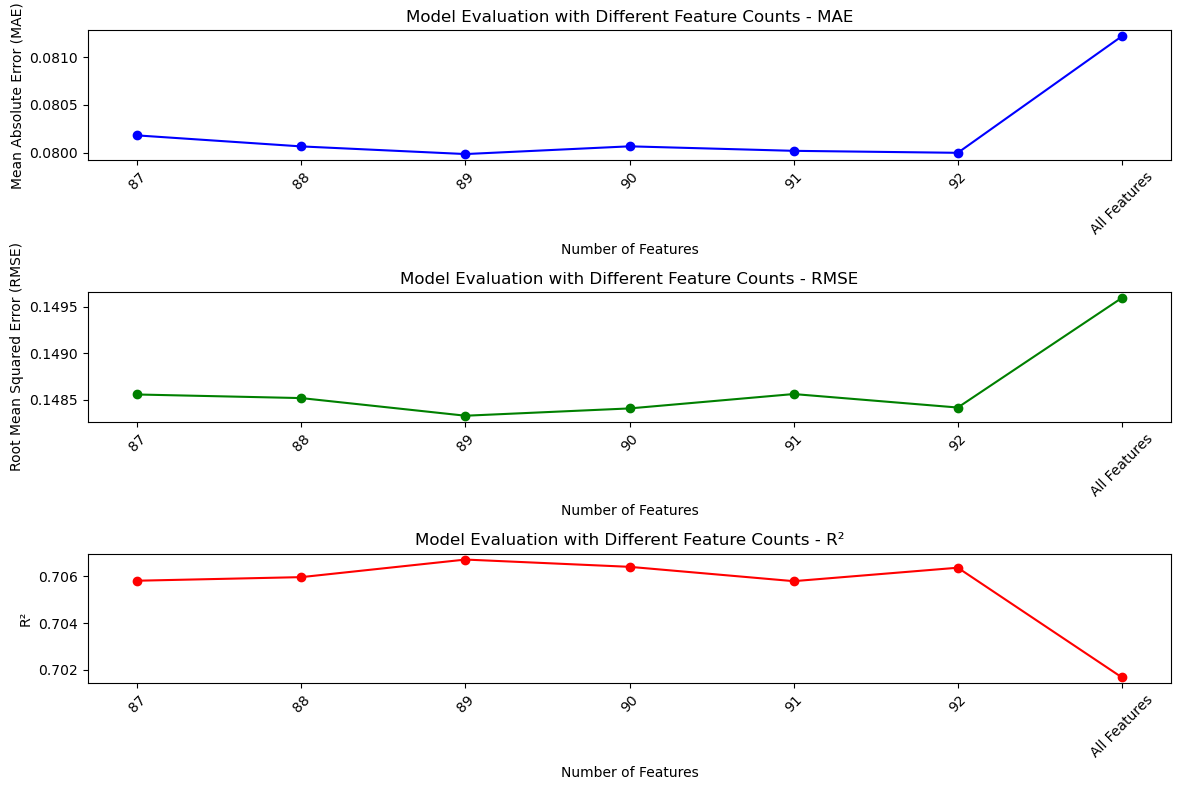

Highest R^2: 89, score: 0.7067
Lowest MAE: 89, score: 0.0800
Lowest RMSE: 89, score: 0.1483


In [41]:
evaluate_model_with_specified_features(X, y, features_df, feature_counts=[87,88,89,90,91,92])


# Automating Finding Optimal Number of Features & Most Important Features via Recursion, Grid Search 
Train a XGBoost to predict the popularity score based on various features (# of most important features, # of episodes. 

## Finding Optimal Number of Features to Reduce Overfitting, Underfitting 
### Approach 1: Using Recursion 

Logic: 
- Winning logic: 2-out-of-3 Logic: Selects a winner if 2 metrics favor one count.
    - Fallback to RMSE: Uses RMSE as a tiebreaker when no clear winner emerges.
- Dynamic Range Adjustment: 
    - 5 feature numbers are evaluated by initially dividing the total feature number by 5. then, we narrow down the range to the neighborhood of the best-performing count for recursion.


Issue: Couldn't figure out best stop / step size logic

In [42]:
import builtins
list = builtins.list #to make sure list isn't define as something else (a bug that took ages to fix haha)

In [43]:
# def evaluate_model(X, y, features_df, feature_count):
#     """
#     Evaluates model performance for a given number of features.
#     Returns the MAE, RMSE, and R² metrics for a model with the specified number of features.
#     """
#     if feature_count == 'All Features':
#         X_selected = X  # Use all features
#     else:
#         top_features = features_df['Feature'].head(feature_count).values
#         X_selected = X[top_features]

#     # Split the dataset into train and test sets
#     X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

#     # Handle missing values by dropping rows with missing data
#     combined_train = pd.concat([X_train, y_train], axis=1).dropna()
#     X_train = combined_train.iloc[:, :-1]  # All columns except the target
#     y_train = combined_train.iloc[:, -1]  # Target column

#     combined_test = pd.concat([X_test, y_test], axis=1).dropna()
#     X_test = combined_test.iloc[:, :-1]
#     y_test = combined_test.iloc[:, -1]

#     # Initialize and train the model
#     model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, random_state=42)
#     model.fit(X_train, y_train)

#     # Make predictions
#     y_pred_test = model.predict(X_test)

#     # Evaluate performance
#     test_mae = mean_absolute_error(y_test, y_pred_test)
#     test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
#     test_r2 = r2_score(y_test, y_pred_test)

#     return test_mae, test_rmse, test_r2


# def compare_metrics(metrics_1, metrics_2):
#     """
#     Compares two sets of metrics using the two-out-of-three rule.
#     Returns True if metrics_1 is better, False otherwise.
#     """
#     mae_1, rmse_1, r2_1 = metrics_1
#     mae_2, rmse_2, r2_2 = metrics_2

#     # Two-out-of-three rule: MAE, RMSE, and R² (higher R² is better)
#     better_count = sum([mae_1 < mae_2, rmse_1 < rmse_2, r2_1 > r2_2])

#     # If two or more metrics are better, metrics_1 wins
#     return better_count >= 2


# def refined_search(X, y, features_df, total_features):
#     """
#     Starts with a set of feature counts, then narrows down the search space progressively.
#     Stops when step size is 1, the improvement is smaller than a tolerance, or max iterations is reached.
#     """
#     # Start with half of the total number of features as the center point.
#     current_best = total_features // 2
#     best_metrics = None
#     best_feature_count = current_best

#     while current_best > 1:
#         # Step size: Divide the current best feature count by 5 and round up to ensure it's large enough for the search.
#         step_size = (current_best // 5) + 1  
#         print(f"Step size: {step_size}")
        
#         # Generate intervals based on the step size: k, 2k, 3k, 4k, 5k.
#         intervals = [step_size * i for i in range(1, 6)]
#         print(f"Initial intervals: {intervals}")
        
#         # Evaluate the model for each of these intervals.
#         for count in intervals:
#             if count > total_features:  # Ensure we don't exceed the number of features.
#                 continue
#             current_metrics = evaluate_model(X, y, features_df, count)
#             print(f"Evaluating {count} features -> MAE: {current_metrics[0]:.4f}, RMSE: {current_metrics[1]:.4f}, R²: {current_metrics[2]:.4f}")
            
#             # Update the best metrics and best feature count if this configuration performs better.
#             if best_metrics is None or compare_metrics(current_metrics, best_metrics):
#                 best_metrics = current_metrics
#                 best_feature_count = count

#         print(f"Best feature count from current set: {best_feature_count}")
        
#         # Refine the search around the best feature count by narrowing the search space.
#         refined_step_size = (best_feature_count // 5) + 1  # Round up for the refined search.
#         refined_intervals = [refined_step_size * i for i in range(1, 6)]  # Refined intervals around the best feature count.
#         print(f"Refining search with intervals: {refined_intervals}")
        
#         # Evaluate again with the refined search space.
#         for count in refined_intervals:
#             if count > total_features:  # Ensure we don't exceed the number of features.
#                 continue
#             current_metrics = evaluate_model(X, y, features_df, count)
#             print(f"Evaluating refined {count} features -> MAE: {current_metrics[0]:.4f}, RMSE: {current_metrics[1]:.4f}, R²: {current_metrics[2]:.4f}")
            
#             # Update the best metrics and best feature count if this configuration performs better.
#             if compare_metrics(current_metrics, best_metrics):
#                 best_metrics = current_metrics
#                 best_feature_count = count
        
#         # Update the current best feature count to be the best found in the current search
#         current_best = best_feature_count
        
#         # Stop when we have very close intervals, i.e., when the step size becomes 1.
#         if refined_step_size == 1:
#             break

#     return best_feature_count, best_metrics


# # Example usage:
# total_features = 233  # Example: total number of features
# best_feature_count, best_metrics = refined_search(X, y, features_df, total_features)

# # Print the optimal feature count and corresponding metrics
# print(f"Optimal feature count: {best_feature_count}")
# print(f"Metrics -> MAE: {best_metrics[0]:.4f}, RMSE: {best_metrics[1]:.4f}, R²: {best_metrics[2]:.4f}")



### Approach 2: Divide and Conquer, Binary Search Method (too long) 

In [44]:
def evaluate_model(X, y, features_df, feature_count):
    """
    Evaluates model performance for a given number of features.
    Returns the MAE, RMSE, and R² metrics for a model with the specified number of features.
    """
    if feature_count == 'All Features':
        X_selected = X  # Use all features
    else:
        top_features = features_df['Feature'].head(feature_count).values
        X_selected = X[top_features]

    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Handle missing values by dropping rows with missing data
    combined_train = pd.concat([X_train, y_train], axis=1).dropna()
    X_train = combined_train.iloc[:, :-1]  # All columns except the target
    y_train = combined_train.iloc[:, -1]  # Target column

    combined_test = pd.concat([X_test, y_test], axis=1).dropna()
    X_test = combined_test.iloc[:, :-1]
    y_test = combined_test.iloc[:, -1]

    # Initialize and train the model
    model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_test = model.predict(X_test)

    # Evaluate performance
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_r2 = r2_score(y_test, y_pred_test)

    return test_mae, test_rmse, test_r2


def compare_metrics(metrics_1, metrics_2):
    """
    Compares two sets of metrics using the two-out-of-three rule.
    Returns True if metrics_1 is better, False otherwise.
    """
    mae_1, rmse_1, r2_1 = metrics_1
    mae_2, rmse_2, r2_2 = metrics_2

    # Two-out-of-three rule: MAE, RMSE, and R² (higher R² is better)
    better_count = sum([mae_1 < mae_2, rmse_1 < rmse_2, r2_1 > r2_2])

    # If two or more metrics are better, metrics_1 wins
    return better_count >= 2


def binary_search_optimal_feature_count(X, y, features_df, low, high):
    """
    Performs binary search to find the optimal number of features using the two-out-of-three rule.
    """
    best_feature_count = low
    best_metrics = None

    while low <= high:
        mid = (low + high) // 2
        print(f"Evaluating {mid} features...")

        # Evaluate the model with the middle feature count
        current_metrics = evaluate_model(X, y, features_df, mid)

        # Initialize best metrics if none are set
        if best_metrics is None or compare_metrics(current_metrics, best_metrics):
            best_metrics = current_metrics
            best_feature_count = mid

        # Adjust the search space based on the comparison
        if compare_metrics(current_metrics, best_metrics):
            print(f"New best found with {mid} features.")
            best_metrics = current_metrics
            best_feature_count = mid
            high = mid - 1  # Move to the left half to potentially find better features
        else:
            print(f"Exploring right half, no improvement.")
            low = mid + 1  # Move to the right half for a better solution

    return best_feature_count, best_metrics




### Approach 3: Bayesian Optimization, Grid Search (too long, need more time)

### Bayesian Optimization 

In [45]:

# from skopt import BayesSearchCV
# from skopt.space import Integer, Real

# # Assuming `df` is your dataframe
# # Split data into features (X) and target (y)
# y = df['popularity']
# X = df.drop(columns=['id', 'popularity'])  # Drop ID and target column

# # Split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Combine X_train and y_train to handle missing values together
# train_combined = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
# train_combined = train_combined.dropna()  # Remove rows with missing values

# # Split back into X_train and y_train
# X_train = train_combined.drop(columns=['popularity']).to_numpy()
# y_train = train_combined['popularity'].to_numpy()

# # Combine X_test and y_test to handle missing values together
# test_combined = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
# test_combined = test_combined.dropna()  # Remove rows with missing values

# # Split back into X_test and y_test
# X_test = test_combined.drop(columns=['popularity']).to_numpy()
# y_test = test_combined['popularity'].to_numpy()

# # Verify data integrity
# print("X_train shape:", X_train.shape)
# print("y_train shape:", y_train.shape)
# print("X_test shape:", X_test.shape)
# print("y_test shape:", y_test.shape)

# # Define the search space for Bayesian Optimization
# search_space = {
#     'max_depth': Integer(3, 15),  # Range for max_depth
#     'learning_rate': Real(0.01, 0.2),  # Range for learning_rate
#     'n_estimators': Integer(50, 500),  # Range for n_estimators
#     'subsample': Real(0.5, 1.0)  # Range for subsample
# }

# # Set up BayesSearchCV to optimize hyperparameters using Bayesian optimization
# opt = BayesSearchCV(
#     estimator=XGBRegressor(random_state=42),
#     search_spaces=search_space,
#     n_iter=50,  # Number of iterations (function evaluations)
#     scoring='neg_mean_squared_error',  # Evaluation metric (neg_MSE for regression)
#     n_jobs=-1,  # Use all CPUs
#     cv=3,  # 3-fold cross-validation
#     random_state=42
# )

# # Fit the model with Bayesian optimization
# opt.fit(X_train, y_train)

# # Get the best hyperparameters and print them
# print("Best hyperparameters found by Bayesian Optimization:", opt.best_params_)

# # Get the best score (negative MSE)
# print("Best score (negative MSE):", opt.best_score_)

# # Train the final model with the best hyperparameters found by BayesSearchCV
# best_model = opt.best_estimator_

# # Make predictions
# y_pred_train = best_model.predict(X_train)
# y_pred_test = best_model.predict(X_test)

# # Evaluate the model
# train_mae = mean_absolute_error(y_train, y_pred_train)
# train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))  
# train_r2 = r2_score(y_train, y_pred_train)

# test_mae = mean_absolute_error(y_test, y_pred_test)
# test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))  
# test_r2 = r2_score(y_test, y_pred_test)

# # Print results
# print("Results with XGBoost after Bayesian Optimization:")
# print(f"Train MAE: {train_mae:.4f}")
# print(f"Train RMSE: {train_rmse:.4f}")  
# print(f"Train R^2: {train_r2:.4f}")
# print(f"Test MAE: {test_mae:.4f}")
# print(f"Test RMSE: {test_rmse:.4f}") 
# print(f"Test R^2: {test_r2:.4f}")


| **Approach**          | **Time Complexity**                              | **Advantages**                                              | **Disadvantages**                                          |
|------------------------|--------------------------------------------------|------------------------------------------------------------|------------------------------------------------------------|
| **Recursion**          | \(O(n^2)\) or \(O(n \log_2(n))\) with optimizations | Dynamically narrows the search space; easy to customize; fewer evaluations in optimized versions. | Still more expensive than Bayesian Optimization; may need manual adjustments (e.g., range narrowing). |
| **Grid Search**        | \(O(n \cdot f)\)                                 | Exhaustive, guarantees best result in the specified range.  | Computationally expensive for large feature counts \(n\).   |
| **Bayesian Optimization** | \(O(k \cdot f)\), where \(k \ll n\)             | Efficient for large ranges; intelligently explores the space. | Slightly complex to implement; dependent on the optimization library. |


## Determining Feature Importance: Number of Episodes 
'number_of_episodes' and 'popularity' 

In [83]:
original_df = pd.read_csv('original_dataset.csv')


In [84]:
print(original_df['number_of_episodes'].value_counts())


1        27886
0        24016
6         9656
8         7162
4         7097
         ...  
10456        1
3483         1
518          1
2924         1
1094         1
Name: number_of_episodes, Length: 967, dtype: int64


In [86]:
import pandas as pd

# Re-align original_df to match the rows of df (or X_train)
original_df_aligned = original_df.loc[df.index].reset_index(drop=True)

# Now replace the 'number_of_episodes' column in df with the aligned column from original_df
df['number_of_episodes'] = original_df_aligned['number_of_episodes']

# Verify the change
print(df[['number_of_episodes']].head())  # Check the first few rows to confirm


   number_of_episodes
0                73.0
1                41.0
2                34.0
3               177.0
4                93.0


In [91]:
# Find the minimum and maximum values in 'number_of_episodes' column
min_episodes = df['number_of_episodes'].min()
max_episodes = df['number_of_episodes'].max()

print(f"Min episodes: {min_episodes}")
print(f"Max episodes: {max_episodes}")


Min episodes: 0.0
Max episodes: 20839.0


In [92]:
# Define the range of episodes to evaluate
min_episodes = 0  # Replace this with your desired minimum episode count
max_episodes = 20839  # Replace this with your desired maximum episode count

# Initialize variables for tracking the best result
best_score = float('inf')  # Start with a very high score for RMSE comparison
best_episode_count = None
best_metrics = None

# Function to compare two sets of metrics using the two-out-of-three rule
def compare_metrics(metrics_1, metrics_2):
    """
    Compares two sets of metrics (MAE, RMSE, R²) using the two-out-of-three rule.
    Returns True if metrics_1 is better, False otherwise.
    """
    mae_1, rmse_1, r2_1 = metrics_1
    mae_2, rmse_2, r2_2 = metrics_2

    # Compare the metrics based on the two-out-of-three rule:
    better_count = sum([mae_1 < mae_2, rmse_1 < rmse_2, r2_1 > r2_2])
    
    # Return True if metrics_1 wins at least 2 out of 3
    return better_count >= 2

# Iterate over the number of episodes and evaluate the models
for episode_count in range(min_episodes, max_episodes + 1):
    print(f"Evaluating for {episode_count} episodes...")
    
    # Filter the data for the current number of episodes
    df_filtered = df[df['number_of_episodes'] == episode_count]

    if len(df_filtered) == 0:  # Skip if there are no records for this number of episodes
        continue

    # Split data into features (X) and target (y)
    y = df_filtered['popularity']
    X = df_filtered.drop(columns=['id', 'popularity'])  # Drop ID and target column

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Combine X_train and y_train to handle missing values together
    train_combined = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
    train_combined = train_combined.dropna()  # Remove rows with missing values

    # Split back into X_train and y_train
    X_train = train_combined.drop(columns=['popularity']).to_numpy()
    y_train = train_combined['popularity'].to_numpy()

    # Combine X_test and y_test to handle missing values together
    test_combined = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
    test_combined = test_combined.dropna()  # Remove rows with missing values

    # Split back into X_test and y_test
    X_test = test_combined.drop(columns=['popularity']).to_numpy()
    y_test = test_combined['popularity'].to_numpy()

    # Initialize and train the model
    xgb = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, random_state=42)
    xgb.fit(X_train, y_train)

    # Make predictions
    y_pred_test = xgb.predict(X_test)

    # Evaluate the model
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_r2 = r2_score(y_test, y_pred_test)

    # Print metrics for the current model
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test R^2: {test_r2:.4f}")

    # Track the best result using the two-out-of-three rule
    if best_metrics is None or compare_metrics((test_mae, test_rmse, test_r2), best_metrics):
        best_score = test_rmse
        best_episode_count = episode_count
        best_metrics = (test_mae, test_rmse, test_r2)

# Print the optimal episode count and corresponding metrics
print(f"\nOptimal number of episodes: {best_episode_count}")
print(f"Best Metrics: MAE={best_metrics[0]:.4f}, RMSE={best_metrics[1]:.4f}, R^2={best_metrics[2]:.4f}")


Evaluating for 0 episodes...
Test MAE: 0.0579
Test RMSE: 0.1272
Test R^2: 0.4819
Evaluating for 1 episodes...
Test MAE: 0.0617
Test RMSE: 0.1286
Test R^2: 0.4795
Evaluating for 2 episodes...
Test MAE: 0.0681
Test RMSE: 0.1359
Test R^2: 0.3632
Evaluating for 3 episodes...
Test MAE: 0.0705
Test RMSE: 0.1360
Test R^2: 0.4675
Evaluating for 4 episodes...
Test MAE: 0.0782
Test RMSE: 0.1466
Test R^2: 0.4392
Evaluating for 5 episodes...
Test MAE: 0.0806
Test RMSE: 0.1575
Test R^2: 0.4193
Evaluating for 6 episodes...
Test MAE: 0.0761
Test RMSE: 0.1449
Test R^2: 0.4840
Evaluating for 7 episodes...
Test MAE: 0.0775
Test RMSE: 0.1496
Test R^2: 0.4663
Evaluating for 8 episodes...
Test MAE: 0.0889
Test RMSE: 0.1585
Test R^2: 0.5741
Evaluating for 9 episodes...
Test MAE: 0.0890
Test RMSE: 0.1604
Test R^2: 0.5139
Evaluating for 10 episodes...
Test MAE: 0.0853
Test RMSE: 0.1573
Test R^2: 0.5892
Evaluating for 11 episodes...
Test MAE: 0.0937
Test RMSE: 0.1702
Test R^2: 0.3383
Evaluating for 12 episodes

/Users/serenakim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Test MAE: 0.2387
Test RMSE: 0.2387
Test R^2: nan
Evaluating for 238 episodes...
Test MAE: 0.0124
Test RMSE: 0.0175
Test R^2: 0.9988
Evaluating for 239 episodes...
Test MAE: 0.0748
Test RMSE: 0.1067
Test R^2: 0.9488
Evaluating for 240 episodes...
Test MAE: 0.1985
Test RMSE: 0.2716
Test R^2: 0.5931
Evaluating for 241 episodes...
Test MAE: 0.0584
Test RMSE: 0.0816
Test R^2: 0.9682
Evaluating for 242 episodes...
Test MAE: 0.7033
Test RMSE: 0.7123
Test R^2: -38.8256
Evaluating for 243 episodes...
Test MAE: 0.1604
Test RMSE: 0.1762
Test R^2: 0.8660
Evaluating for 244 episodes...
Test MAE: 0.1577
Test RMSE: 0.1577
Test R^2: nan
Evaluating for 245 episodes...
Test MAE: 0.3163
Test RMSE: 0.4368
Test R^2: -834.4068
Evaluating for 246 episodes...


/Users/serenakim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Test MAE: 0.0796
Test RMSE: 0.0853
Test R^2: 0.9640
Evaluating for 247 episodes...
Test MAE: 0.3615
Test RMSE: 0.4386
Test R^2: 0.2063
Evaluating for 248 episodes...
Test MAE: 0.1021
Test RMSE: 0.1021
Test R^2: nan
Evaluating for 249 episodes...
Test MAE: 0.2287
Test RMSE: 0.2368
Test R^2: 0.7477
Evaluating for 250 episodes...


/Users/serenakim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/serenakim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Test MAE: 0.1575
Test RMSE: 0.2326
Test R^2: 0.7448
Evaluating for 251 episodes...
Test MAE: 0.0282
Test RMSE: 0.0397
Test R^2: 0.9937
Evaluating for 252 episodes...
Test MAE: 0.0002
Test RMSE: 0.0002
Test R^2: nan
Evaluating for 253 episodes...
Test MAE: 0.2212
Test RMSE: 0.2220
Test R^2: 0.8028
Evaluating for 254 episodes...
Test MAE: 0.0159
Test RMSE: 0.0159
Test R^2: nan
Evaluating for 255 episodes...


/Users/serenakim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Test MAE: 0.2857
Test RMSE: 0.3031
Test R^2: 0.5573
Evaluating for 256 episodes...
Test MAE: 0.4243
Test RMSE: 0.5745
Test R^2: -0.3403
Evaluating for 257 episodes...
Test MAE: 0.5010
Test RMSE: 0.5157
Test R^2: 0.0000
Evaluating for 258 episodes...
Test MAE: 0.3719
Test RMSE: 0.5081
Test R^2: -0.0654
Evaluating for 259 episodes...
Test MAE: 0.1719
Test RMSE: 0.2231
Test R^2: 0.7557
Evaluating for 260 episodes...
Test MAE: 0.2263
Test RMSE: 0.2578
Test R^2: 0.6692
Evaluating for 261 episodes...
Test MAE: 0.4504
Test RMSE: 0.5942
Test R^2: -0.5471
Evaluating for 262 episodes...
Test MAE: 0.2415
Test RMSE: 0.3751
Test R^2: 0.3068
Evaluating for 263 episodes...
Test MAE: 0.1263
Test RMSE: 0.1263
Test R^2: 0.0000
Evaluating for 264 episodes...
Test MAE: 0.1627
Test RMSE: 0.1732
Test R^2: 0.8238
Evaluating for 265 episodes...
Test MAE: 0.0001
Test RMSE: 0.0001
Test R^2: 0.0000
Evaluating for 266 episodes...
Test MAE: 0.0051
Test RMSE: 0.0051
Test R^2: nan
Evaluating for 267 episodes...
Test

/Users/serenakim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Test MAE: 0.1921
Test RMSE: 0.2296
Test R^2: 0.7691
Evaluating for 271 episodes...
Test MAE: 0.0403
Test RMSE: 0.0403
Test R^2: 0.0000
Evaluating for 272 episodes...
Test MAE: 0.2437
Test RMSE: 0.2948
Test R^2: 0.6032
Evaluating for 273 episodes...
Test MAE: 0.4531
Test RMSE: 0.5086
Test R^2: 0.0000
Evaluating for 274 episodes...
Test MAE: 0.7037
Test RMSE: 0.7501
Test R^2: 0.0000
Evaluating for 275 episodes...
Test MAE: 0.3470
Test RMSE: 0.4258
Test R^2: 0.1841
Evaluating for 276 episodes...
Test MAE: 0.0164
Test RMSE: 0.0231
Test R^2: 0.9977
Evaluating for 277 episodes...
Test MAE: 0.1868
Test RMSE: 0.2542
Test R^2: -0.8509
Evaluating for 278 episodes...
Test MAE: 0.3536
Test RMSE: 0.3578
Test R^2: 0.4880
Evaluating for 279 episodes...
Test MAE: 0.0271
Test RMSE: 0.0308
Test R^2: 0.9961
Evaluating for 280 episodes...
Test MAE: 0.3432
Test RMSE: 0.4808
Test R^2: -539.7530
Evaluating for 281 episodes...
Test MAE: 0.0559
Test RMSE: 0.0575
Test R^2: 0.9868
Evaluating for 282 episodes...


/Users/serenakim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Test MAE: 0.5870
Test RMSE: 0.7119
Test R^2: -169.7185
Evaluating for 289 episodes...
Test MAE: 0.6817
Test RMSE: 0.7454
Test R^2: 0.0000
Evaluating for 290 episodes...
Test MAE: 0.5470
Test RMSE: 0.5592
Test R^2: -646.3670
Evaluating for 291 episodes...
Test MAE: 0.2849
Test RMSE: 0.2928
Test R^2: 0.6141
Evaluating for 292 episodes...
Test MAE: 0.1008
Test RMSE: 0.1422
Test R^2: 0.0000
Evaluating for 293 episodes...
Test MAE: 0.3208
Test RMSE: 0.5549
Test R^2: -0.3876
Evaluating for 294 episodes...
Test MAE: 0.6111
Test RMSE: 0.7186
Test R^2: 0.0000
Evaluating for 295 episodes...
Test MAE: 0.5534
Test RMSE: 0.5534
Test R^2: nan
Evaluating for 296 episodes...
Test MAE: 0.3678
Test RMSE: 0.4432
Test R^2: -5.7572
Evaluating for 297 episodes...
Test MAE: 0.1685
Test RMSE: 0.1685
Test R^2: nan
Evaluating for 298 episodes...


/Users/serenakim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/serenakim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/serenakim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/serenakim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Test MAE: 0.0084
Test RMSE: 0.0084
Test R^2: nan
Evaluating for 299 episodes...
Test MAE: 0.0373
Test RMSE: 0.0373
Test R^2: nan
Evaluating for 300 episodes...
Test MAE: 0.1074
Test RMSE: 0.1243
Test R^2: 0.9180
Evaluating for 301 episodes...
Test MAE: 0.2605
Test RMSE: 0.3659
Test R^2: 0.3790
Evaluating for 302 episodes...
Test MAE: 0.7583
Test RMSE: 0.8176
Test R^2: -35.5151
Evaluating for 303 episodes...


/Users/serenakim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/serenakim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Test MAE: 0.1969
Test RMSE: 0.1969
Test R^2: nan
Evaluating for 304 episodes...
Test MAE: 0.0381
Test RMSE: 0.0381
Test R^2: 0.0000
Evaluating for 305 episodes...
Test MAE: 0.4226
Test RMSE: 0.4365
Test R^2: -11.0166
Evaluating for 306 episodes...
Test MAE: 0.9971
Test RMSE: 0.9971
Test R^2: nan
Evaluating for 307 episodes...
Test MAE: 0.2524
Test RMSE: 0.3421
Test R^2: 0.5163
Evaluating for 308 episodes...
Test MAE: 0.0007
Test RMSE: 0.0007
Test R^2: 0.0000
Evaluating for 309 episodes...
Test MAE: 0.0140
Test RMSE: 0.0140
Test R^2: 0.0000
Evaluating for 310 episodes...
Test MAE: 0.6322
Test RMSE: 0.7745
Test R^2: -1.9183
Evaluating for 311 episodes...
Test MAE: 0.3369
Test RMSE: 0.4714
Test R^2: -0.9576
Evaluating for 312 episodes...
Test MAE: 0.0216
Test RMSE: 0.0234
Test R^2: 0.9975
Evaluating for 313 episodes...


/Users/serenakim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/serenakim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/serenakim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/serenakim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Test MAE: 0.5535
Test RMSE: 0.5535
Test R^2: nan
Evaluating for 314 episodes...
Test MAE: 0.1774
Test RMSE: 0.1774
Test R^2: nan
Evaluating for 315 episodes...
Test MAE: 0.5457
Test RMSE: 0.5457
Test R^2: nan
Evaluating for 316 episodes...
Test MAE: 0.4153
Test RMSE: 0.4359
Test R^2: -0.1018
Evaluating for 317 episodes...
Test MAE: 0.6057
Test RMSE: 0.6057
Test R^2: nan
Evaluating for 318 episodes...
Test MAE: 0.2807
Test RMSE: 0.3426
Test R^2: -2.0013
Evaluating for 319 episodes...
Test MAE: 0.1049
Test RMSE: 0.1053
Test R^2: 0.9433
Evaluating for 320 episodes...
Test MAE: 0.0058
Test RMSE: 0.0073
Test R^2: 0.9934
Evaluating for 321 episodes...
Test MAE: 0.2543
Test RMSE: 0.3070
Test R^2: 0.5383
Evaluating for 322 episodes...
Test MAE: 0.5191
Test RMSE: 0.6582
Test R^2: -0.7332
Evaluating for 323 episodes...
Test MAE: 0.0004
Test RMSE: 0.0004
Test R^2: nan
Evaluating for 324 episodes...


/Users/serenakim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/serenakim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/serenakim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/serenakim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/serenakim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 scor

Test MAE: 0.0000
Test RMSE: 0.0000
Test R^2: nan
Evaluating for 325 episodes...
Test MAE: 0.0044
Test RMSE: 0.0044
Test R^2: 0.0000
Evaluating for 326 episodes...
Test MAE: 0.0138
Test RMSE: 0.0138
Test R^2: nan
Evaluating for 327 episodes...
Test MAE: 0.0189
Test RMSE: 0.0243
Test R^2: 0.9976
Evaluating for 328 episodes...
Test MAE: 0.8661
Test RMSE: 0.8661
Test R^2: nan
Evaluating for 329 episodes...
Test MAE: 0.0720
Test RMSE: 0.0720
Test R^2: nan
Evaluating for 330 episodes...


ValueError: With n_samples=1, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [88]:
import optuna
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    
    # Initialize model with trial's hyperparameters
    model = XGBRegressor(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=subsample,
        random_state=42
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate on the validation set
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return rmse

# Create study object to optimize
study = optuna.create_study(direction='minimize')  # 'minimize' RMSE
study.optimize(objective, n_trials=100)

print("Best hyperparameters: ", study.best_params)
print("Best RMSE: ", study.best_value)


[I 2024-11-26 16:03:47,810] A new study created in memory with name: no-name-cb4c5a8c-8fa8-4116-9463-bb6bee739dcf
[I 2024-11-26 16:04:05,700] Trial 0 finished with value: 0.1506325252707028 and parameters: {'max_depth': 8, 'learning_rate': 0.05796994808927276, 'n_estimators': 53, 'subsample': 0.9729013932818718}. Best is trial 0 with value: 0.1506325252707028.
[I 2024-11-26 16:04:27,590] Trial 1 finished with value: 0.17587726653496427 and parameters: {'max_depth': 4, 'learning_rate': 0.014765188890260815, 'n_estimators': 130, 'subsample': 0.7036060857081958}. Best is trial 0 with value: 0.1506325252707028.
[I 2024-11-26 16:04:51,727] Trial 2 finished with value: 0.14858484585439194 and parameters: {'max_depth': 8, 'learning_rate': 0.0823862266781298, 'n_estimators': 76, 'subsample': 0.9130433958894087}. Best is trial 2 with value: 0.14858484585439194.
[I 2024-11-26 16:06:07,161] Trial 3 finished with value: 0.14794870960733736 and parameters: {'max_depth': 10, 'learning_rate': 0.09129

KeyboardInterrupt: 